In [103]:
import sys
import pandas as pd
import yfinance as yf
import warnings

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

from google.oauth2.service_account import Credentials
from googleapiclient.discovery import build

from yahooquery import Ticker
from polygon import RESTClient

import os
import requests
from datetime import datetime
from dateutil.relativedelta import relativedelta

warnings.filterwarnings("ignore", category=FutureWarning)

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [104]:
from dotenv import load_dotenv
import os

load_dotenv()

POLYGON_API_KEY = os.getenv("POLYGON_API_KEY")

if POLYGON_API_KEY:
    print("API Key successfully loaded!")
else:
    print("Error: API Key not found!")

ALPHA_VANTAGE_API_KEY = os.getenv("ALPHA_VANTAGE_API_KEY")

API Key successfully loaded!


In [105]:
import gspread

# gc = gspread.service_account(filename='stocksflags-ec5c40f2f2ee.json')
gc = gspread.service_account(filename='rational-diode-456114-m0-79243525427e.json')


ginzu_spreadsheet_link = 'https://docs.google.com/spreadsheets/d/1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks/edit?usp=sharing'
pricer = gc.open_by_url(ginzu_spreadsheet_link)
input_worksheet = pricer.get_worksheet(0)
valuation_worksheet = pricer.get_worksheet(1)

In [106]:
SCOPES = ['https://www.googleapis.com/auth/spreadsheets']
SERVICE_ACCOUNT_FILE = 'rational-diode-456114-m0-79243525427e.json'

spreadsheet_id = '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks'
sheet_name = 'Input sheet'

creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
service = build('sheets', 'v4', credentials=creds)

In [107]:
def get_related_tickers(ticker):
    client = RESTClient(POLYGON_API_KEY)
    try:
        related = client.get_related_companies(ticker.upper())
        return [r.ticker for r in related]
    except Exception as e:
        print(f"Error fetching related companies: {e}")
        return []

In [108]:
def get_dropdown_options(spreadsheet_id: str, sheet_name: str, cell: str) -> list:
    """
    Given a spreadsheet ID, sheet name, and cell (e.g., 'B7'),
    returns the dropdown options (either hardcoded or from a range).
    """
    range_name = f"'{sheet_name}'!{cell}"
    
    try:
        response = service.spreadsheets().get(
            spreadsheetId=spreadsheet_id,
            ranges=[range_name],
            includeGridData=True,
            fields='sheets.data.rowData.values.dataValidation'
        ).execute()

        validation = response['sheets'][0]['data'][0]['rowData'][0]['values'][0]['dataValidation']
        condition = validation['condition']
        dropdown_values = [v['userEnteredValue'] for v in condition.get('values', [])]

        dropdown_ref = dropdown_values[0]
        if dropdown_ref.startswith("="):
            raw_ref = dropdown_ref.lstrip("=").replace("'", "")
            ref_sheet, ref_range = raw_ref.split("!")

            country_resp = service.spreadsheets().values().get(
                spreadsheetId=spreadsheet_id,
                range=f"{ref_sheet}!{ref_range}"
            ).execute()

            return [row[0].strip() for row in country_resp.get("values", []) if row and row[0].strip()]
        else:
            return dropdown_values

    except (KeyError, IndexError):
        print(f"No dropdown (data validation) found at {sheet_name}!{cell}.")
        return []


In [109]:
def get_alpha_vantage_data(function, symbol):
    url = f"https://www.alphavantage.co/query?function={function}&symbol={symbol}&apikey={ALPHA_VANTAGE_API_KEY}"
    response = requests.get(url)
    return response.json()

In [110]:
def safe_float(value):
    try:
        # Attempt to convert to float; if it fails, return 0
        return float(value) if value not in [None, 'None', ''] else 0
    except ValueError:
        return 0.0

In [111]:
def get_latest_10k_financials(symbol):
    overview_data = get_alpha_vantage_data("OVERVIEW", symbol)
    income_data = get_alpha_vantage_data("INCOME_STATEMENT", symbol)
    balance_data = get_alpha_vantage_data("BALANCE_SHEET", symbol)
    quote_data = get_alpha_vantage_data("TIME_SERIES_DAILY", symbol)

    try:
        company_name = overview_data["Name"]
        inc_reports = income_data["annualReports"]
        bal_reports = balance_data["annualReports"]
        price_series = quote_data["Time Series (Daily)"]
    except KeyError:
        raise ValueError("Missing data from Alpha Vantage. Check symbol or API limit.")

    inc_reports.sort(key=lambda x: x["fiscalDateEnding"], reverse=True)
    bal_reports.sort(key=lambda x: x["fiscalDateEnding"], reverse=True)

    inc_curr, inc_prev = inc_reports[0], inc_reports[1]
    bal_curr, bal_prev = bal_reports[0], bal_reports[1]

    b11 = safe_float(inc_curr.get("totalRevenue", 0))
    c11 = safe_float(inc_prev.get("totalRevenue", 0))

    b12 = safe_float(inc_curr.get("ebit", 0))
    c12 = safe_float(inc_prev.get("ebit", 0))

    b13 = safe_float(inc_curr.get("interestExpense", 0))
    c13 = safe_float(inc_prev.get("interestExpense", 0))

    b14 = safe_float(bal_curr.get("totalShareholderEquity", 0))
    c14 = safe_float(bal_prev.get("totalShareholderEquity", 0))

    current_debt = safe_float(bal_curr.get("currentDebt", 0))
    long_term_debt = safe_float(bal_curr.get("currentLongTermDebt", 0))  
    b15 = current_debt + long_term_debt 

    prev_current_debt = safe_float(bal_prev.get("currentDebt", 0))
    prev_long_term_debt = safe_float(bal_prev.get("currentLongTermDebt", 0)) 
    c15 = prev_current_debt + prev_long_term_debt

    b18 = safe_float(bal_curr.get("cashAndCashEquivalentsAtCarryingValue", 0))
    c18 = safe_float(bal_prev.get("cashAndCashEquivalentsAtCarryingValue", 0))

    b19 = safe_float(bal_curr.get("otherCurrentAssets", 0)) 
    c19 = safe_float(bal_prev.get("otherCurrentAssets", 0)) 

    b20 = safe_float(bal_curr.get("totalShareholderEquity", 0)) - safe_float(bal_curr.get("commonStockEquity", 0))
    c20 = safe_float(bal_prev.get("totalShareholderEquity", 0)) - safe_float(bal_prev.get("commonStockEquity", 0))

    b21 = int(bal_curr.get("commonStockSharesOutstanding", 0))

    # Get most recent stock price
    latest_day = sorted(price_series.keys())[-1]
    b22 = safe_float(price_series[latest_day]["4. close"])

    d11 = relativedelta(datetime.strptime(inc_curr["fiscalDateEnding"], "%Y-%m-%d"),
                        datetime.strptime(inc_prev["fiscalDateEnding"], "%Y-%m-%d")).years

    b16 = "Yes" if "researchAndDevelopment" in inc_curr or "researchAndDevelopment" in inc_prev else "No"

    b17 = "Yes" if "operatingLease" in inc_curr or "operatingLease" in inc_prev else "No"

    # Calculate Effective Tax Rate (B23)
    income_tax_expense = safe_float(inc_curr.get("incomeTaxExpense", 0))
    pre_tax_income = safe_float(inc_curr.get("ebit", 0))  # EBIT as proxy for pre-tax income
    b23 = income_tax_expense / pre_tax_income if pre_tax_income != 0 else 0

    b24 = 0.21 

    # Define rf w/ 10 year treasury yield
    b33 = 0.04378

    return {
        "B11": b11, "C11": c11, "D11": d11,
        "B12": b12, "C12": c12, "B13": b13, "C13": c13,
        "B14": b14, "C14": c14, "B15": b15, "C15": c15,
        "B16": b16, "B17": b17,
        "B18": b18, "C18": c18, "B19": b19, "C19": c19,
        "B20": b20, "C20": c20, "B21": b21, "B22": b22,
        "B23": b23, "B24": b24, "B4": company_name,
        "B33": b33,
    }

In [112]:
company_ticker = input("Enter the company ticker: ")

In [113]:
financials = get_latest_10k_financials(company_ticker)

ValueError: Missing data from Alpha Vantage. Check symbol or API limit.

In [114]:
financials

{'B11': 245122000000.0,
 'C11': 211915000000.0,
 'D11': 1,
 'B12': 110722000000.0,
 'C12': 91279000000.0,
 'B13': 2935000000.0,
 'C13': 1968000000.0,
 'B14': 268477000000.0,
 'C14': 206223000000.0,
 'B15': 8942000000.0,
 'C15': 5247000000.0,
 'B16': 'Yes',
 'B17': 'No',
 'B18': 18315000000.0,
 'C18': 34704000000.0,
 'B19': 26033000000.0,
 'C19': 21807000000.0,
 'B20': 268477000000.0,
 'C20': 206223000000.0,
 'B21': 7469000000,
 'B22': 438.17,
 'B23': 0.17748053684001372,
 'B24': 0.21,
 'B4': 'Microsoft Corporation',
 'B33': 0.04378}

## Date of Valuation and Company Name

In [115]:
def retrieve_date():
    valuation_date = datetime.today()
    formatted_date = valuation_date.strftime('%b-%d')
    return formatted_date

In [116]:
date_of_valuation = retrieve_date()
company_name = financials["B4"]
input_worksheet.update('B3', [[date_of_valuation]])
input_worksheet.update('B4', [[company_name]])

{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!B4",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Country of Incorporation, Industry (Global) and Industry (US)

In [117]:
def prompt_user_choice(options_list, prompt_message="Please choose an option:"):
    print("\nYou can type part of the name to search for matches.")
    print("Example: typing 'tech' will show 'Technology', 'Biotech', etc.\n")

    while True:
        search_input = input(f"{prompt_message} (type to search): ").strip().lower()
        
        matching_options = [opt for opt in options_list if search_input in opt.lower()]
        
        if not matching_options:
            print("No matches found. Please try again.")
            continue

        print("\nMatches found:")
        for idx, opt in enumerate(matching_options[:10], start=1):
            print(f"{idx}. {opt}")
        
        if len(matching_options) > 10:
            print(f"...and {len(matching_options) - 10} more matches.\n")
        else:
            print("") 

        selected_option = input("Type your exact choice from the matches above: ").strip()
        selected_exact = [opt for opt in matching_options if opt.lower() == selected_option.lower()]
        
        if selected_exact:
            return selected_exact[0]
        else:
            print("Invalid selection from matches. Please try again.\n")


In [118]:
country_names = get_dropdown_options(spreadsheet_id, sheet_name, 'B7')
us_industry = get_dropdown_options(spreadsheet_id, sheet_name, 'B8')
global_industry = get_dropdown_options(spreadsheet_id, sheet_name, 'B9')

In [119]:
country_names

['Abu Dhabi',
 'Albania',
 'Algeria',
 'Andorra (Principality of)',
 'Angola',
 'Anguilla',
 'Antigua & Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Channel Islands',
 'Chile',
 'China',
 'Colombia',
 'Congo (Democratic Republic of)',
 'Congo (Republic of)',
 'Cook Islands',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Curaçao',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Estonia',
 'Ethiopia',
 'Falkland Islands',
 'Fiji',
 'Finland',
 'France',
 'French Guiana',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Gibraltar',
 'Greece',
 'Greenland',
 'Guatemala',
 'Guernsey (St

In [15]:
us_industry

['Advertising',
 'Aerospace/Defense',
 'Air Transport',
 'Apparel',
 'Auto & Truck',
 'Auto Parts',
 'Bank (Money Center)',
 'Banks (Regional)',
 'Beverage (Alcoholic)',
 'Beverage (Soft)',
 'Broadcasting',
 'Brokerage & Investment Banking',
 'Building Materials',
 'Business & Consumer Services',
 'Cable TV',
 'Chemical (Basic)',
 'Chemical (Diversified)',
 'Chemical (Specialty)',
 'Coal & Related Energy',
 'Computer Services',
 'Computers/Peripherals',
 'Construction Supplies',
 'Diversified',
 'Drugs (Biotechnology)',
 'Drugs (Pharmaceutical)',
 'Education',
 'Electrical Equipment',
 'Electronics (Consumer & Office)',
 'Electronics (General)',
 'Engineering/Construction',
 'Entertainment',
 'Environmental & Waste Services',
 'Farming/Agriculture',
 'Financial Svcs. (Non-bank & Insurance)',
 'Food Processing',
 'Food Wholesalers',
 'Furn/Home Furnishings',
 'Green & Renewable Energy',
 'Healthcare Products',
 'Healthcare Support Services',
 'Heathcare Information and Technology',
 'Ho

In [16]:
global_industry

['Advertising',
 'Aerospace/Defense',
 'Air Transport',
 'Apparel',
 'Auto & Truck',
 'Auto Parts',
 'Bank (Money Center)',
 'Banks (Regional)',
 'Beverage (Alcoholic)',
 'Beverage (Soft)',
 'Broadcasting',
 'Brokerage & Investment Banking',
 'Building Materials',
 'Business & Consumer Services',
 'Cable TV',
 'Chemical (Basic)',
 'Chemical (Diversified)',
 'Chemical (Specialty)',
 'Coal & Related Energy',
 'Computer Services',
 'Computers/Peripherals',
 'Construction Supplies',
 'Diversified',
 'Drugs (Biotechnology)',
 'Drugs (Pharmaceutical)',
 'Education',
 'Electrical Equipment',
 'Electronics (Consumer & Office)',
 'Electronics (General)',
 'Engineering/Construction',
 'Entertainment',
 'Environmental & Waste Services',
 'Farming/Agriculture',
 'Financial Svcs. (Non-bank & Insurance)',
 'Food Processing',
 'Food Wholesalers',
 'Furn/Home Furnishings',
 'Green & Renewable Energy',
 'Healthcare Products',
 'Healthcare Support Services',
 'Heathcare Information and Technology',
 'Ho

In [56]:
country = prompt_user_choice(country_names, "Choose a country from the list above:")


You can type part of the name to search for matches.
Example: typing 'tech' will show 'Technology', 'Biotech', etc.


Matches found:
1. United States



In [175]:
us_industry_choice = prompt_user_choice(us_industry, "Choose a US industry from the list above:")


You can type part of the name to search for matches.
Example: typing 'tech' will show 'Technology', 'Biotech', etc.


Matches found:
1. Software (Entertainment)
2. Software (Internet)
3. Software (System & Application)



In [174]:
global_industry_choice = prompt_user_choice(global_industry, "Choose a Global industry from the list above:")


You can type part of the name to search for matches.
Example: typing 'tech' will show 'Technology', 'Biotech', etc.


Matches found:
1. Software (Entertainment)
2. Software (Internet)
3. Software (System & Application)



In [60]:
input_worksheet.update('B7', [[country]])
input_worksheet.update('B8', [[us_industry_choice]])
input_worksheet.update('B9', [[global_industry_choice]])

/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_3998/2968613820.py:1: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B7', [[country]])
/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_3998/2968613820.py:2: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B8', [[us_industry_choice]])
/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_3998/2968613820.py:3: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B9', [[global_industry_choice]])


{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!B9",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Years Since Last 10K

In [120]:
years_since_last_10k = financials["D11"]
input_worksheet.update('D11',[[years_since_last_10k]])

{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!D11",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Revenues (Most Recent 12 Months, Last 10K)

In [121]:
current_revenues = financials["B11"]/10000000
last_10k_revenues = financials["C11"]/10000000
input_worksheet.update('B11', [[current_revenues]])
input_worksheet.update('C11', [[last_10k_revenues]])

{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!C11",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Operating Income / EBIT (Most Recent 12 Months, Last 10K)

In [122]:
current_operating_income = financials["B12"]/10000000
last_10k_operating_income = financials["C12"]/10000000
input_worksheet.update('B12', [[current_operating_income]])
input_worksheet.update('C12', [[last_10k_operating_income]])

{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!C12",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Interest Expense (Most Recent 12 Months, Last 10K)

In [123]:
current_interest_expense = financials["B13"]/10000000
last_10k_interest_expense = financials["C13"]/10000000
input_worksheet.update('B13', [[current_interest_expense]])
input_worksheet.update('C13', [[last_10k_interest_expense]])

{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!C13",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Book Value of Equity (Most Recent 12 Months, Last 10K)

In [124]:
current_book_value_of_equity = financials["B14"]/10000000
last_10k_book_value_of_equity = financials["C14"]/10000000
input_worksheet.update('B14', [[current_book_value_of_equity]])
input_worksheet.update('C14', [[last_10k_book_value_of_equity]])

{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!C14",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Book Value of Debt (Most Recent 12 Months, Last 10K)

In [125]:
current_book_value_of_debt = financials["B15"]/10000000
last_10k_book_value_of_debt = financials["C15"]/10000000
input_worksheet.update('B15', [[current_book_value_of_debt]])
input_worksheet.update('C15', [[last_10k_book_value_of_debt]])

{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!C15",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## R&D Expenses to Capitalize + Operating Lease Commitments

In [126]:
r_and_d = financials["B16"]
operating_lease_commitments = financials["B17"]
input_worksheet.update('B16', [[r_and_d]])
input_worksheet.update('B17', [[operating_lease_commitments]])

{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!B17",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Cash and Marketable Securities (Most Recent 12 Months, Last 10K)

In [127]:
current_cash_and_marketable_securities = financials["B18"]/10000000
last_10k_cash_and_marketable_securities = financials["C18"]/10000000
input_worksheet.update('B18', [[current_cash_and_marketable_securities]])
input_worksheet.update('C18', [[last_10k_cash_and_marketable_securities]])

{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!C18",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Investments (Most Recent 12 Months, Last 10K)

In [128]:
if financials.get("B19") is not None:
    cross_holdings_and_other_non_operating_assets = financials["B19"] / 1e7
    input_worksheet.update('B19', [[cross_holdings_and_other_non_operating_assets]])
else:
    print("B19 (Cross holdings and other non-operating assets) is missing.")

if financials.get("C19") is not None:
    last_10k_cross_holdings_and_other_non_operating_assets = financials["C19"] / 1e7
    input_worksheet.update('C19', [[last_10k_cross_holdings_and_other_non_operating_assets]])
else:
    print("C19 (Last 10K cross holdings and other non-operating assets) is missing.")


## Minority Interests (Most Recent 12 Months, Last 10K)

In [129]:
current_minority_interests = financials["B20"]/10000000
last_10k_minority_interests = financials["C20"]/10000000
input_worksheet.update('B20', [[current_minority_interests]])
input_worksheet.update('C20', [[last_10k_minority_interests]])

{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!C20",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Number of Shares Outstanding, Current Stock Price, Effect and Marginal Tax Rate

In [130]:
number_of_shares_outstanding = financials["B21"]/10000000
current_stock_price = financials["B22"]
effective_tax_rate = financials["B23"]
marginal_tax_rate = financials["B24"]
input_worksheet.update('B21', [[number_of_shares_outstanding]])
input_worksheet.update('B22', [[current_stock_price]])
input_worksheet.update('B23', [[effective_tax_rate]])
input_worksheet.update('B24', [[marginal_tax_rate]])

{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!B24",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Value Drivers (Rev Growth)

In [131]:
def get_annual_revenue(symbol, api_key):
    url = (
        f"https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={symbol}"
        f"&apikey={api_key}"
    )
    response = requests.get(url)
    if response.status_code != 200:
        raise ValueError(f"Request failed with status code {response.status_code}")
    
    data = response.json()
    if "annualReports" not in data:
        raise ValueError(f"No annualReports found for symbol {symbol}. Response: {data}")
    
    reports = data["annualReports"]
    records = []
    for report in reports:
        try:
            date = pd.to_datetime(report["fiscalDateEnding"])
            revenue = int(report["totalRevenue"])
            records.append({"ds": date, "y": revenue})
        except Exception as e:
            print(f"Skipping report due to error: {e}")
    
    df = pd.DataFrame(records).sort_values("ds").reset_index(drop=True)
    return df

In [132]:
# Main forecasting function with automatic tuning of cps
def forecast_revenue_growth_rate(symbol, api_key, history_years=5, cps_grid=None):
    if cps_grid is None:
        cps_grid = [0.01, 0.05, 0.1, 0.2, 0.3]  # Grid for tuning
    
    df_revenue = get_annual_revenue(symbol, api_key)

    # Filter last N years of data
    cutoff_date = pd.Timestamp.today() - pd.DateOffset(years=history_years)
    df_revenue = df_revenue[df_revenue['ds'] >= cutoff_date]
    
    if len(df_revenue) < 4:
        raise ValueError(f"Not enough data to train Prophet for {symbol}")

    # Hyperparameter tuning using cross-validation
    tuning = []
    days_per_year = 365.25
    initial_years = min(3, len(df_revenue) - 1)
    
    for cps in cps_grid:
        m = Prophet(
            yearly_seasonality=False,
            changepoint_prior_scale=cps,
            n_changepoints=min(5, len(df_revenue)-1)
        )
        m.fit(df_revenue)
        try:
            df_cv = cross_validation(
                m,
                initial=f"{int(initial_years * days_per_year)} days",
                period=f"{int(1 * days_per_year)} days",
                horizon=f"{int(1 * days_per_year)} days",
                parallel="processes"
            )
            perf = performance_metrics(df_cv)
            tuning.append({
                "cps": cps,
                "mae": perf['mae'].mean(),
                "mape": perf['mape'].mean(),
                "rmse": perf['rmse'].mean()
            })
        except Exception as e:
            print(f"Cross-validation failed for cps={cps}: {e}")
    
    if not tuning:
        raise RuntimeError("All Prophet cross-validations failed.")

    # Choose best cps by lowest MAPE
    best_cps = min(tuning, key=lambda x: x["mape"])["cps"]

    # Final model with best cps
    model = Prophet(
        yearly_seasonality=False,
        changepoint_prior_scale=best_cps,
        n_changepoints=min(5, len(df_revenue)-1)
    )
    model.fit(df_revenue)

    # Forecast next year
    future = model.make_future_dataframe(periods=1, freq='Y')
    forecast = model.predict(future)
    
    last_actual = df_revenue.iloc[-1]["y"]
    next_forecast = forecast.iloc[-1]["yhat"]

    growth_rate = (next_forecast - last_actual) / last_actual * 100

    # Optional: Plot
    model.plot(forecast)
    plt.title(f"Forecasted Revenue for {symbol}")
    plt.xlabel("Date")
    plt.ylabel("Revenue")
    plt.tight_layout()
    plt.show()

    return {
        "symbol": symbol,
        "last_actual_revenue": last_actual,
        "forecasted_next_year_revenue": next_forecast,
        "growth_rate": growth_rate,
        "best_cps": best_cps
    }

In [133]:
result = forecast_revenue_growth_rate(company_ticker, ALPHA_VANTAGE_API_KEY)
print(f"\nForecasted Revenue Growth for {result['symbol']}: {result['growth_rate']:.2f}%")
print(f"Last Revenue: {result['last_actual_revenue']:.0f}")
print(f"Forecasted Revenue: {result['forecasted_next_year_revenue']:.0f}")
print(f"Optimal changepoint prior scale: {result['best_cps']}")

ValueError: No annualReports found for symbol MSFT. Response: {'Information': 'We have detected your API key as VJ8MMGTTXC4TJ6UR and our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.'}

## Value Drivers (Operating Margin)

In [ ]:
def get_annual_revenue_and_operating_income(symbol: str, api_key: str):
    """
    Fetches the annual income statement data from Alpha Vantage and calculates operating margin.
    Returns a DataFrame with the operating margin over time.
    """
    url = f"https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={symbol}&apikey={api_key}"
    response = requests.get(url)
    
    if response.status_code != 200:
        raise ValueError(f"Request failed with status code {response.status_code}")
    
    data = response.json()
    if "annualReports" not in data:
        raise ValueError(f"No annualReports found for symbol {symbol}. Response: {data}")
    
    reports = data["annualReports"]
    records = []
    
    for report in reports:
        try:
            date = pd.to_datetime(report["fiscalDateEnding"])
            operating_income = float(report["operatingIncome"])
            total_revenue = float(report["totalRevenue"])
            if total_revenue != 0:
                margin = (operating_income / total_revenue) * 100
                records.append({"ds": date, "y": margin})
        except Exception as e:
            print(f"Skipping report due to error: {e}")
    
    df = pd.DataFrame(records).sort_values("ds").reset_index(drop=True)
    return df

In [ ]:
def forecast_operating_margin(symbol: str, api_key: str, history_years: int = 10, cps_grid=None) -> dict:
    """
    Forecasts next year's operating margin (%) using Prophet,
    tuning changepoint_prior_scale via time-series CV on annual data from Alpha Vantage.

    Returns:
      {
        best_cps: float,
        cv_results: DataFrame,
        margin_forecast: float,    # next-year operating margin (%)
        lower_bound: float,
        upper_bound: float,
        forecast_df: DataFrame     # ds, yhat, yhat_lower, yhat_upper
      }
    """
    # Default changepoint prior scale grid
    if cps_grid is None:
        cps_grid = [0.01, 0.05, 0.1, 0.3, 0.5]
    
    # 1) Pull annual statements from Alpha Vantage
    df_margin = get_annual_revenue_and_operating_income(symbol, api_key)

    # 2) Use only the last `history_years` years of data
    cutoff_date = pd.Timestamp.today() - pd.DateOffset(years=history_years)
    df_margin = df_margin[df_margin['ds'] >= cutoff_date]
    
    if len(df_margin) < 2:
        raise ValueError(f"Not enough data to train Prophet for {symbol}")
    
    # 3) Prepare data for Prophet
    df = df_margin[['ds', 'y']]

    # 4) Determine if tuning is feasible
    cv_results = pd.DataFrame()
    total_days = (df['ds'].max() - df['ds'].min()).days
    horizon_days = 365
    if total_days >= 2 * horizon_days:
        # Compute initial window to leave horizon_days for testing
        initial_days = total_days - horizon_days
        tuning = []
        for cps in cps_grid:
            m = Prophet(
                yearly_seasonality=False,
                changepoint_prior_scale=cps,
                n_changepoints=min(5, len(df)-1)
            )
            m.fit(df)
            df_cv = cross_validation(
                m,
                initial=f"{initial_days} days",
                period="365 days",    # One year
                horizon="365 days",
                parallel="processes"
            )
            perf = performance_metrics(df_cv)
            tuning.append({
                'cps': cps,
                'mae': perf['mae'].mean(),
                'mape': perf['mape'].mean(),
                'rmse': perf['rmse'].mean()
            })
        cv_results = pd.DataFrame(tuning)
        best_cps = cv_results.loc[cv_results['mape'].idxmin(), 'cps']
    else:
        best_cps = 0.05

    # 5) Fit final model with the best changepoint prior scale
    model = Prophet(
        yearly_seasonality=False,
        changepoint_prior_scale=best_cps,
        n_changepoints=min(5, len(df)-1)
    )
    model.fit(df)

    # 6) Forecast the next year
    future = model.make_future_dataframe(periods=1, freq='A')
    forecast = model.predict(future)
    last = forecast.iloc[-1]
    margin_forecast = last['yhat']
    lower, upper = last['yhat_lower'], last['yhat_upper']

    # 7) Visualization
    plt.figure(figsize=(10,6))
    plt.plot(df['ds'], df['y'], 'o-', label='Historical Margin')
    plt.plot(forecast['ds'], forecast['yhat'], '--', label='Forecast')
    plt.fill_between(
        forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
        color='orange', alpha=0.3, label='Uncertainty'
    )
    plt.axvline(df['ds'].iloc[-1], color='gray', linestyle=':')
    plt.title(f"{symbol} Operating Margin Forecast (cps={best_cps})")
    plt.xlabel("Year")
    plt.ylabel("Operating Margin (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'best_cps': best_cps,
        'cv_results': cv_results,
        'margin_forecast': margin_forecast,
        'lower_bound': lower,
        'upper_bound': upper,
        'forecast_df': forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    }

16:51:58 - cmdstanpy - INFO - Chain [1] start processing
16:51:59 - cmdstanpy - INFO - Chain [1] done processing
/Users/tylerni/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
16:52:01 - cmdstanpy - INFO - Chain [1] start processing
16:52:01 - cmdstanpy - INFO - Chain [1] done processing
16:52:01 - cmdstanpy - INFO - Chain [1] start processing
16:52:01 - cmdstanpy - INFO - Chain [1] done processing
/Users/tylerni/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
16:52:02 - cmdstanpy - INFO - Chain [1] start processing
16:52:02 - cmdstanpy - INFO - Chain [1] done processing
16:52:02 - cmdstanpy - INFO - Chain [1] start processing
16:52:02 - cmdstanpy - INFO - Chain [1] don

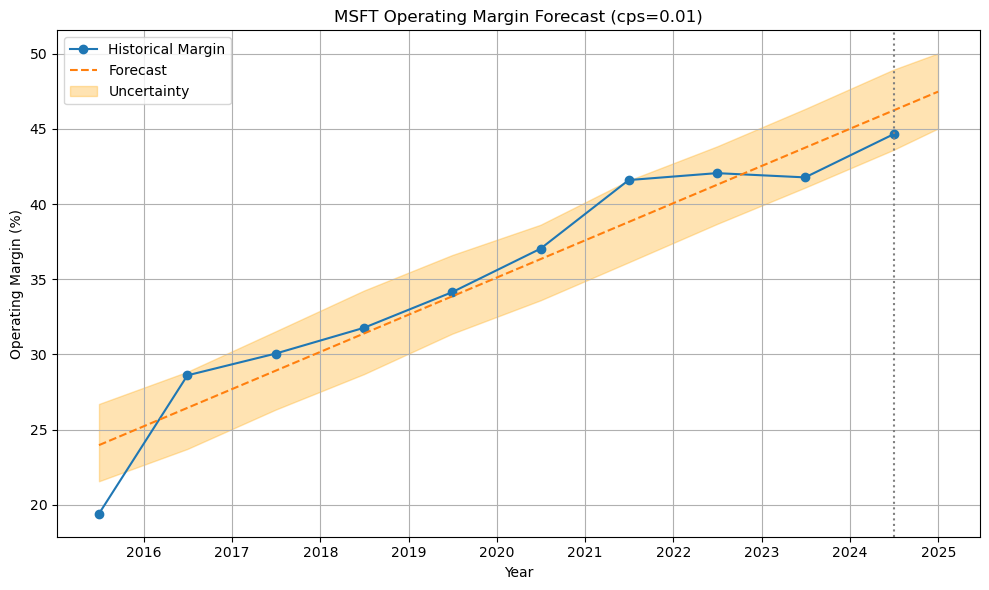

Forecasted Operating Margin for 2025: 47.47%
Lower Bound: 45.02%
Upper Bound: 50.02%
Optimal changepoint prior scale: 0.01


In [ ]:
result = forecast_operating_margin(company_ticker, ALPHA_VANTAGE_API_KEY)
latest_year = result['forecast_df']['ds'].dt.year.max()
forecasted_year = latest_year + 1
print(f"Forecasted Operating Margin for {forecasted_year}: {result['margin_forecast']:.2f}%")
print(f"Lower Bound: {result['lower_bound']:.2f}%")
print(f"Upper Bound: {result['upper_bound']:.2f}%")
print(f"Optimal changepoint prior scale: {result['best_cps']}")

## Value Drivers (CAGR)

In [ ]:
def get_annual_revenue(symbol: str, api_key: str, history_years: int = 15) -> pd.DataFrame:
    """
    Fetches the annual income statement data from Alpha Vantage and extracts revenue.
    
    Args:
      symbol (str): stock ticker
      api_key (str): Alpha Vantage API key
      history_years (int): number of years of historical data to fetch

    Returns:
      DataFrame with revenue history for the last `history_years` years
    """
    url = f"https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={symbol}&apikey={api_key}"
    response = requests.get(url)
    
    if response.status_code != 200:
        raise ValueError(f"Request failed with status code {response.status_code}")
    
    data = response.json()
    
    if "annualReports" not in data:
        raise ValueError(f"No annualReports found for symbol {symbol}. Response: {data}")
    
    reports = data["annualReports"]
    records = []
    
    for report in reports:
        try:
            date = pd.to_datetime(report["fiscalDateEnding"])
            total_revenue = float(report["totalRevenue"])
            records.append({"ds": date, "y": total_revenue})
        except Exception as e:
            print(f"Skipping report due to error: {e}")
    
    df = pd.DataFrame(records).sort_values("ds").reset_index(drop=True)
    
    # Use only the last `history_years` years of data
    cutoff_date = pd.Timestamp.today() - pd.DateOffset(years=history_years)
    df = df[df['ds'] >= cutoff_date]
    
    return df

def forecast_revenue_cagr(
    symbol: str,
    api_key: str,
    forecast_years: int = 5,
    history_years: int = 15,
    cps_grid: list = [0.05, 0.1, 0.2, 0.3, 0.5],
    growth: str = 'linear',
    plot: bool = True
) -> dict:
    """
    Forecast revenue with Prophet, auto-tuning changepoint_prior_scale (CPS).

    Args:
      symbol (str): stock ticker
      api_key (str): Alpha Vantage API key
      forecast_years (int): how many years forward to forecast
      history_years (int): how much historical data to use
      cps_grid (list): list of CPS values to try
      growth (str): 'linear' or 'logistic'
      plot (bool): whether to plot results

    Returns:
      dict with initial revenue, forecast revenue, CAGR, bounds, best CPS
    """
    # 1) Pull data from Alpha Vantage
    df = get_annual_revenue(symbol, api_key, history_years)
    
    if len(df) < 3:
        raise ValueError(f"Not enough revenue history for tuning ({symbol})")

    # 2) Auto-tune CPS by splitting into train/validation
    errors = []
    for cps in cps_grid:
        model = Prophet(
            growth=growth,
            yearly_seasonality=False,
            changepoint_prior_scale=cps,
            n_changepoints=min(10, len(df)-1)
        )
        if growth == 'logistic':
            cap = df['y'].max() * 1.5
            df['cap'] = cap

        model.fit(df.iloc[:-1])  # train on all but last year

        future = model.make_future_dataframe(periods=1, freq='A')
        if growth == 'logistic':
            future['cap'] = cap

        forecast = model.predict(future)

        predicted = forecast['yhat'].iloc[-1]
        actual = df['y'].iloc[-1]
        error = np.abs(predicted - actual) / actual  # relative error
        errors.append((cps, error))

    # 3) Choose best CPS
    best_cps, best_error = min(errors, key=lambda x: x[1])
    print(f"Best CPS: {best_cps:.3f} with validation error: {best_error:.2%}")

    # 4) Retrain model on full data
    model = Prophet(
        growth=growth,
        yearly_seasonality=False,
        changepoint_prior_scale=best_cps,
        n_changepoints=min(10, len(df)-1)
    )
    if growth == 'logistic':
        cap = df['y'].max() * 1.5
        df['cap'] = cap

    model.fit(df)

    future = model.make_future_dataframe(periods=forecast_years, freq='A')
    if growth == 'logistic':
        future['cap'] = cap

    forecast = model.predict(future)

    # 5) Compute CAGRs
    initial_revenue = df['y'].iloc[-1]
    forecast_row = forecast.iloc[-1]
    forecast_revenue = forecast_row['yhat']
    lower_revenue = forecast_row['yhat_lower']
    upper_revenue = forecast_row['yhat_upper']

    n = forecast_years
    cagr_forecast = (forecast_revenue / initial_revenue) ** (1/n) - 1
    lower_bound = (lower_revenue / initial_revenue) ** (1/n) - 1
    upper_bound = (upper_revenue / initial_revenue) ** (1/n) - 1

    if plot:
        plt.figure(figsize=(10,6))
        plt.plot(df['ds'], df['y'], 'o-', label='Historical Revenue')
        plt.plot(forecast['ds'], forecast['yhat'], '--', label='Forecast Revenue')
        plt.fill_between(
            forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
            color='orange', alpha=0.3, label='Uncertainty'
        )
        plt.axvline(df['ds'].iloc[-1], color='gray', linestyle=':')
        plt.title(f"{symbol} Revenue Forecast (5 Years) [Best CPS={best_cps}]")
        plt.xlabel("Year")
        plt.ylabel("Revenue (USD)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return {
        'initial_revenue': initial_revenue,
        'forecast_revenue': forecast_revenue,
        'cagr_forecast': cagr_forecast * 100,
        'lower_bound': lower_bound * 100,
        'upper_bound': upper_bound * 100,
        'forecast_df': forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
        'best_cps': best_cps
    }

17:02:50 - cmdstanpy - INFO - Chain [1] start processing
17:02:51 - cmdstanpy - INFO - Chain [1] done processing
17:02:51 - cmdstanpy - INFO - Chain [1] start processing
17:02:51 - cmdstanpy - INFO - Chain [1] done processing
17:02:51 - cmdstanpy - INFO - Chain [1] start processing
17:02:51 - cmdstanpy - INFO - Chain [1] done processing
17:02:51 - cmdstanpy - INFO - Chain [1] start processing
17:02:51 - cmdstanpy - INFO - Chain [1] done processing
17:02:51 - cmdstanpy - INFO - Chain [1] start processing
17:02:51 - cmdstanpy - INFO - Chain [1] done processing
17:02:51 - cmdstanpy - INFO - Chain [1] start processing
17:02:52 - cmdstanpy - INFO - Chain [1] done processing


Best CPS: 0.500 with validation error: 7.47%


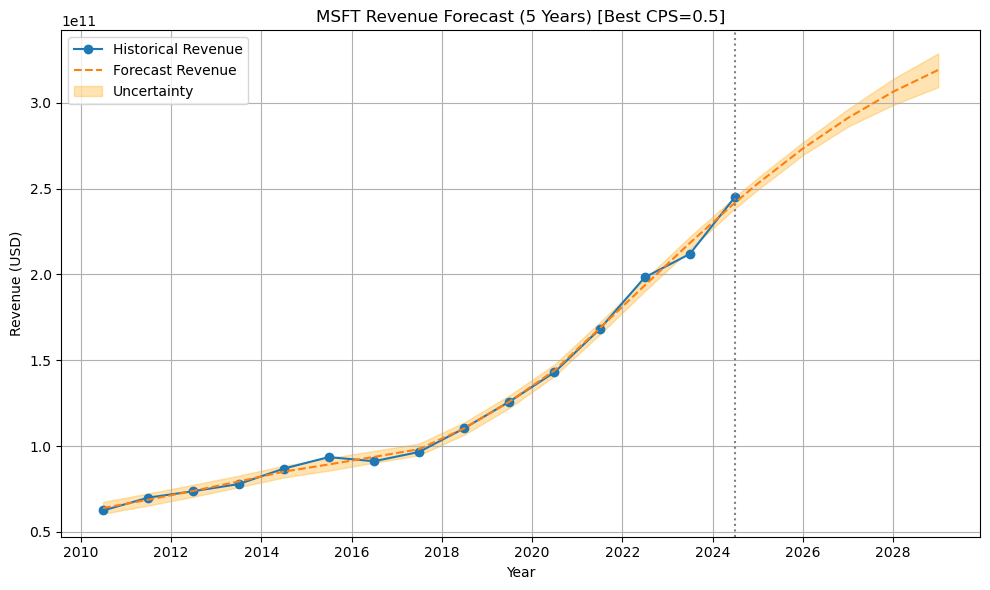

5-Year Forecasted CAGR: 5.42%
90% confidence: 4.75% → 6.05%
Tuned CPS: 0.50


In [ ]:
result = forecast_revenue_cagr(
    company_ticker,
    ALPHA_VANTAGE_API_KEY,
    forecast_years=5,
    growth='logistic'
)

print(f"5-Year Forecasted CAGR: {result['cagr_forecast']:.2f}%")
print(f"90% confidence: {result['lower_bound']:.2f}% → {result['upper_bound']:.2f}%")
print(f"Tuned CPS: {result['best_cps']:.2f}")

## Value Drivers (Target Pre-Tax Operating Margin, Years to Convergence)

In [ ]:
def forecast_operating_margin(symbol: str, history_years: int = 5, api_key: str = ALPHA_VANTAGE_API_KEY) -> dict:
    """
    Forecasts the Target Pre-Tax Operating Margin and estimates
    how many years it'll take to converge using Alpha Vantage API data.

    Returns:
      {
        'current_margin': float (%),
        'target_margin': float (%),
        'annual_change': float (%/year),
        'years_to_converge': float,
        'margin_trend_df': DataFrame
      }
    """
    # 1. Pull financials from Alpha Vantage API
    url = f'https://www.alphavantage.co/query'
    params = {
        'function': 'INCOME_STATEMENT',
        'symbol': symbol,
        'apikey': api_key
    }
    
    try:
        response = requests.get(url, params=params)
        data = response.json()

        # Check if the data was successfully fetched
        if 'annualReports' not in data:
            raise ValueError(f"No annual income statement data available for {symbol}")

        income_statement = pd.DataFrame(data['annualReports'])
    except Exception as e:
        raise ValueError(f"Failed to fetch data from Alpha Vantage: {e}")
    
    # Ensure data is in correct format
    income_statement = income_statement[['fiscalDateEnding', 'operatingIncome', 'totalRevenue']]
    income_statement['fiscalDateEnding'] = pd.to_datetime(income_statement['fiscalDateEnding'])
    income_statement = income_statement.sort_values('fiscalDateEnding')
    
    # 2. Calculate operating margin (EBIT / TotalRevenue)
    income_statement['operating_margin'] = income_statement['operatingIncome'].astype(float) / income_statement['totalRevenue'].astype(float)
    
    # 3. Limit to recent history
    recent = income_statement.tail(history_years)
    
    if len(recent) < 2:
        raise ValueError("Not enough historical margin data for trend estimation.")

    # 4. Fit linear trend (year vs margin)
    X = recent['fiscalDateEnding'].dt.year.values.reshape(-1, 1)
    y = recent['operating_margin'].values

    model = LinearRegression()
    model.fit(X, y)

    slope = model.coef_[0]   # margin change per year
    intercept = model.intercept_

    # 5. Forecast target margin (say, extrapolate +5 years ahead)
    future_year = X[-1][0] + 5
    target_margin = model.predict(np.array([[future_year]]))[0]

    # 6. Current margin
    current_margin = y[-1]

    # 7. Time to converge
    if np.isclose(slope, 0):
        years_to_converge = np.inf  # Never converges
    else:
        years_to_converge = (target_margin - current_margin) / slope

    # 8. Package results
    margin_trend_df = pd.DataFrame({'year': X.flatten(), 'operating_margin': y})

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(recent['fiscalDateEnding'].dt.year, recent['operating_margin'], 'o-', label='Historical Operating Margin', color='blue')
    plt.plot(recent['fiscalDateEnding'].dt.year, model.predict(X), '--', label='Regression Line', color='green')
    plt.axvline(future_year, color='red', linestyle=':', label=f'Forecast for {future_year}')
    plt.scatter(future_year, target_margin, color='red', zorder=5)
    plt.text(future_year, target_margin, f'Target Margin: {target_margin*100:.2f}%', 
             verticalalignment='bottom', horizontalalignment='right', color='red')
    
    plt.title(f'{symbol} Operating Margin Forecast and Convergence')
    plt.xlabel('Year')
    plt.ylabel('Operating Margin (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'current_margin': current_margin * 100,
        'target_margin': target_margin * 100,
        'annual_change': slope * 100,
        'years_to_converge': years_to_converge,
        'margin_trend_df': margin_trend_df
    }


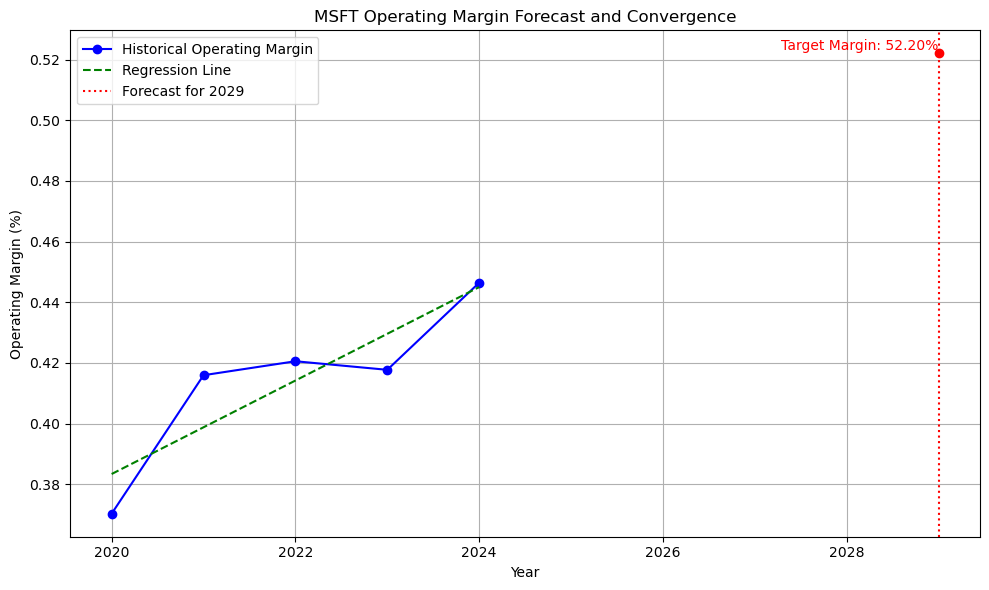

Current Margin: 44.64%
Target Margin (5yr): 52.20%
Annual Change: 1.54% per year
Years to Converge: 4.9 years


In [ ]:
result = forecast_operating_margin(company_ticker, history_years=5, api_key=ALPHA_VANTAGE_API_KEY)

print(f"Current Margin: {result['current_margin']:.2f}%")
print(f"Target Margin (5yr): {result['target_margin']:.2f}%")
print(f"Annual Change: {result['annual_change']:.2f}% per year")
print(f"Years to Converge: {result['years_to_converge']:.1f} years")

## Value Drivers (Sales to Capital Ratio)

In [134]:
def forecast_sales_to_capital_ratio(
    symbol: str,
    history_years: int = 15,
    cps: float = 0.05,
    api_key: str = ALPHA_VANTAGE_API_KEY
) -> dict:
    """
    Forecasts the sales-to-capital ratio (Revenue / InvestedCapital) for
    the next 1–5 years and 6–10 years using Alpha Vantage API data and Prophet.

    Returns:
      {
        'avg_1_5': float,      # average ratio for years 1–5
        'avg_6_10': float,     # average ratio for years 6–10
        'forecast_df': DataFrame  # full 10-year forecast with yhat, yhat_lower, yhat_upper
      }
    """
    # 1) Fetch annual data from Alpha Vantage API
    # Fetch Income Statement (Total Revenue)
    url_income = f'https://www.alphavantage.co/query'
    params_income = {
        'function': 'INCOME_STATEMENT',
        'symbol': symbol,
        'apikey': api_key
    }
    try:
        response_income = requests.get(url_income, params=params_income)
        data_income = response_income.json()
        if 'annualReports' not in data_income:
            raise ValueError(f"No income statement data available for {symbol}")
        income_data = pd.DataFrame(data_income['annualReports'])
    except Exception as e:
        raise ValueError(f"Failed to fetch income data from Alpha Vantage: {e}")

    # Fetch Balance Sheet (Total Assets as a proxy for Invested Capital)
    url_balance = f'https://www.alphavantage.co/query'
    params_balance = {
        'function': 'BALANCE_SHEET',
        'symbol': symbol,
        'apikey': api_key
    }
    try:
        response_balance = requests.get(url_balance, params=params_balance)
        data_balance = response_balance.json()
        if 'annualReports' not in data_balance:
            raise ValueError(f"No balance sheet data available for {symbol}")
        balance_data = pd.DataFrame(data_balance['annualReports'])
    except Exception as e:
        raise ValueError(f"Failed to fetch balance sheet data from Alpha Vantage: {e}")
    
    # 2) Keep only 12M rows and parse dates
    income_data = income_data[['fiscalDateEnding', 'totalRevenue']].copy()
    balance_data = balance_data[['fiscalDateEnding', 'totalAssets']].copy()
    
    income_data['fiscalDateEnding'] = pd.to_datetime(income_data['fiscalDateEnding'])
    balance_data['fiscalDateEnding'] = pd.to_datetime(balance_data['fiscalDateEnding'])
    
    # 3) Merge Revenue & Invested Capital on date
    df = pd.merge(
        income_data[['fiscalDateEnding', 'totalRevenue']],
        balance_data[['fiscalDateEnding', 'totalAssets']],
        on='fiscalDateEnding',
        how='inner'
    ).sort_values('fiscalDateEnding')

    # 4) Limit to the last history_years (drop any nulls)
    cutoff = df['fiscalDateEnding'].max() - pd.DateOffset(years=history_years)
    df = df[df['fiscalDateEnding'] >= cutoff].dropna(subset=['totalRevenue', 'totalAssets'])

    # 5) Compute the ratio (Revenue / Invested Capital)
    df['ratio'] = df['totalRevenue'].astype(float) / df['totalAssets'].astype(float)

    # 6) Prepare for Prophet
    df_prophet = df[['fiscalDateEnding', 'ratio']].rename(columns={'fiscalDateEnding': 'ds', 'ratio': 'y'})

    # 7) Fit Prophet model
    m = Prophet(
        yearly_seasonality=False,
        changepoint_prior_scale=cps
    )
    m.fit(df_prophet)

    # 8) Forecast 10 years ahead (1–10)
    future = m.make_future_dataframe(periods=10, freq='A')
    fc = m.predict(future)

    # 9) Extract just the 10 forecast points (after the last historical year)
    last_hist = df_prophet['ds'].max()
    fut = fc[fc['ds'] > last_hist].reset_index(drop=True)

    # 10) Compute averages for years 1–5 and 6–10
    avg_1_5  = fut.loc[0:4, 'yhat'].mean()
    avg_6_10 = fut.loc[5:9, 'yhat'].mean()

    # 11) Plot historical + forecast
    plt.figure(figsize=(10, 5))
    plt.plot(df_prophet['ds'], df_prophet['y'], 'o-', label='Historical Ratio')
    plt.plot(fut['ds'], fut['yhat'], '--', label='Forecast Ratio')
    plt.fill_between(fut['ds'], fut['yhat_lower'], fut['yhat_upper'],
                     color='orange', alpha=0.3, label='Uncertainty')
    plt.axvline(last_hist, color='gray', linestyle=':')
    plt.title(f"{symbol} Sales-to-Capital Ratio Forecast")
    plt.xlabel("Year")
    plt.ylabel("Revenue / Invested Capital")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'avg_1_5': avg_1_5,
        'avg_6_10': avg_6_10,
        'forecast_df': fut[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    }

In [135]:
result = forecast_sales_to_capital_ratio(company_ticker, history_years=10, cps=0.1, api_key=ALPHA_VANTAGE_API_KEY)

print(f"Sales-to-Capital (Years 1–5): {result['avg_1_5']:.2f}")
print(f"Sales-to-Capital (Years 6–10): {result['avg_6_10']:.2f}")

ValueError: Failed to fetch income data from Alpha Vantage: No income statement data available for MSFT

In [136]:
rev_growth_rate_for_next_year = input('What is the revenue growth rate for the next year?')
operating_margin_for_next_year = input('What is the operating margin for the next year?')
compounded_annual_growth_rate = input('What is the compounded annual growth rate?')
target_pre_tax_operating_margin = input('What is the target pre-tax operating margin?')
years_of_convergence_for_margin = input('How many years of convergence for the margin?')
sales_to_capital_ratio_for_years_1_to_5 = input('What is the sales to capital ratio for the first 5 years?')
sales_to_capital_ratio_for_years_6_to_10 = input('What is the sales to capital ratio for the last 5 years?')
input_worksheet.update('B26', [[rev_growth_rate_for_next_year]])
input_worksheet.update('B27', [[operating_margin_for_next_year]])
input_worksheet.update('B28', [[compounded_annual_growth_rate]])
input_worksheet.update('B29', [[target_pre_tax_operating_margin]])
input_worksheet.update('B30', [[years_of_convergence_for_margin]])
input_worksheet.update('B31', [[sales_to_capital_ratio_for_years_1_to_5]])
input_worksheet.update('B32', [[sales_to_capital_ratio_for_years_6_to_10]])

{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!B32",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Market Numbers

In [138]:
rf = financials["B34"]
input_worksheet.update('B34', [[rf]])

KeyError: 'B34'

## Valuation Metrics

In [139]:
valuation_worksheet.acell('B33').value

' $ 279.81 '

In [140]:
valuation_worksheet.acell('B34').value

' $ 438.17 '

In [141]:
valuation_worksheet.acell('B35').value

'156.60%'